# Umap from Metadata

This notebook loads a csv and builds a Umap visualisation around one metadata column.

See: `save_wikidata_images.ipynb` to save a csv from Wikidata and to create a folder containing images of artworks.

### Import Variables

In [45]:
import pandas as pd
import numpy as np
import altair as alt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer

### Read Data

In [46]:
url = "../assets/query.csv"
data = pd.read_csv(url)

Define the csv column to build the umap from.url = "assets/data.csv"
data = pd.read_csv(url)

In [47]:
data.head()

,item,pic,title
0,http://www.wikidata.org/entity/Q17319807,http://commons.wikimedia.org/wiki/Special:File...,Self Portrait
1,http://www.wikidata.org/entity/Q17319946,http://commons.wikimedia.org/wiki/Special:File...,The Riding School
2,http://www.wikidata.org/entity/Q17319700,http://commons.wikimedia.org/wiki/Special:File...,Portrait of a Man
3,http://www.wikidata.org/entity/Q17319667,http://commons.wikimedia.org/wiki/Special:File...,The Castle of Batavia
4,http://www.wikidata.org/entity/Q17319672,http://commons.wikimedia.org/wiki/Special:File...,The Ruins of the Old Town Hall of Amsterdam af...


In [48]:
metadata = "title"

In [49]:
selection = data[metadata]

In [50]:
selection

0                                          Self Portrait
1                                      The Riding School
2                                      Portrait of a Man
3                                  The Castle of Batavia
4      The Ruins of the Old Town Hall of Amsterdam af...
                             ...                        
495      Interior of the Sint-Odulphuskerk in Assendelft
496                       River Landscape with Boar Hunt
497    Triptych with the Last Judgement outer wings: ...
498              Rembrandt’s Son Titus in a Monk’s Habit
499                                      The Love Letter
Name: title, Length: 500, dtype: object

## Training

In [51]:
from sklearn.feature_extraction.text import CountVectorizer
cv = CountVectorizer()

components = cv.fit_transform(selection)
components.shape

(500, 1157)

In [65]:
import umap.umap_ as umap

reducer = umap.UMAP(
        n_neighbors=7,
        min_dist=1
)

pipe = Pipeline([('scaling', StandardScaler()), ('umap', reducer)])
embedding = pipe.fit_transform(components.toarray())

umap_positions = pd.DataFrame(embedding, columns=["x", "y"])

data_umap = pd.concat([data, umap_positions], axis = 1)

In [66]:
x_domain = [data_umap["x"].min(), data_umap["x"].max() ]
y_domain = [data_umap["y"].min(), data_umap["y"].max() ]

### Display the cluster

In [67]:
alt.Chart(data_umap).mark_circle().encode(
    alt.X('x', scale=alt.Scale(domain=x_domain), axis=alt.Axis(labels=False)),
    alt.Y('y', scale=alt.Scale(domain=y_domain), axis=alt.Axis(labels=False)),
    tooltip=metadata
).properties(width=400, height=400)

alt.Chart(...)

In [68]:
tx, ty = data_umap["x"].dropna(), data_umap["y"].dropna()
tx = (tx-np.min(tx)) / (np.max(tx) - np.min(tx))
ty = (ty-np.min(ty)) / (np.max(ty) - np.min(ty))

### Add images

Specify the path where to load the images

In [69]:
path = '../assets/wikidata_crop/'

In [70]:
ids = data['item'].tolist()

### Plots the clusters

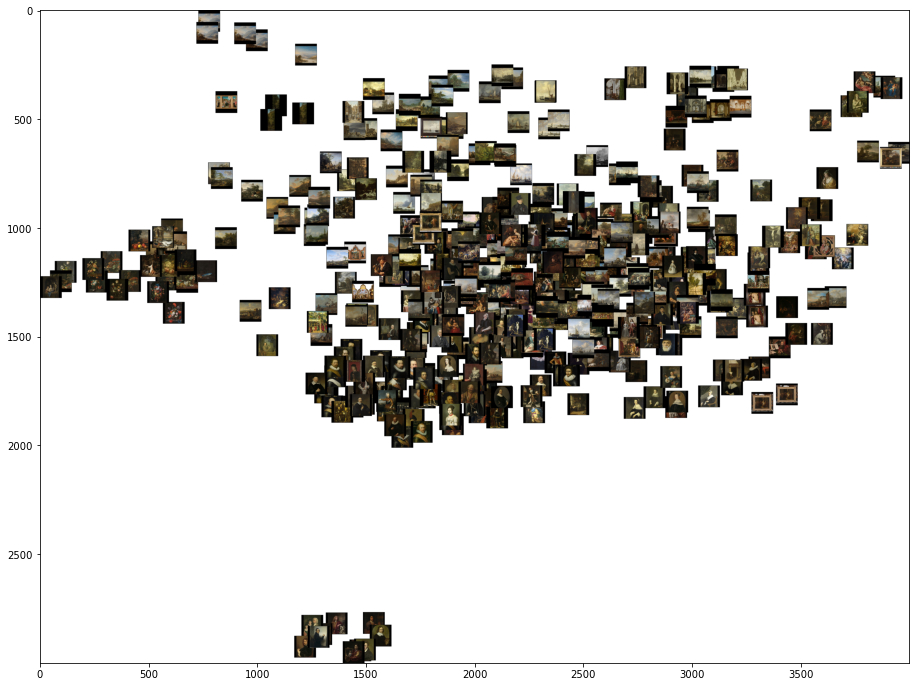

In [71]:
import matplotlib.pyplot
from PIL import Image
from matplotlib.pyplot import imshow

width = 4000
height = 3000
max_dim = 100

full_image = Image.new('RGBA', (width, height))

for imgId, x, y in zip(ids, tx, ty):
    img = path + str(imgId.replace("http://www.wikidata.org/entity/","")) + ".jpg"
    tile = Image.open(img)
    rs = max(1, tile.width/max_dim, tile.height/max_dim)
    tile = tile.resize((int(tile.width/rs), int(tile.height/rs)), Image.ANTIALIAS)
    full_image.paste(tile, (int((width-max_dim)*x), int((height-max_dim)*y)), mask=tile.convert('RGBA'))

        
matplotlib.pyplot.figure(figsize = (16,12))
imshow(full_image)

### Paste into a grid

In [72]:
import rasterfairy
nx = 20
ny = 20

grid_assignment = rasterfairy.transformPointCloud2D(embedding)

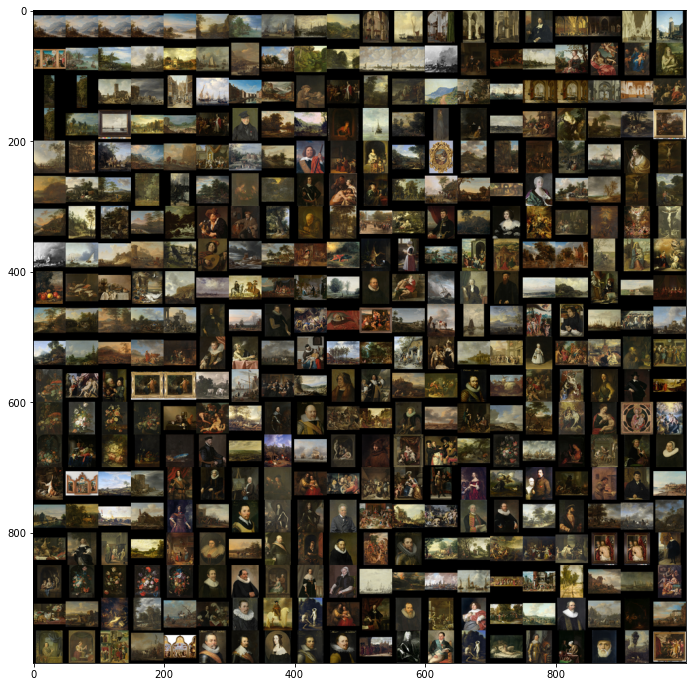

In [75]:
tile_width = 50
tile_height = 50

full_width = tile_width * nx
full_height = tile_height * ny
aspect_ratio = float(tile_width) / tile_height

grid_image = Image.new('RGBA', (full_width, full_height))

for imgId, grid_pos in zip(ids, grid_assignment[0]):
    img = path + str(imgId.replace("http://www.wikidata.org/entity/","")) + ".jpg"
    tile = Image.open(img)
    idx_x, idx_y = grid_pos
    x, y = tile_width * idx_x, tile_height * idx_y
    tile = Image.open(img)
    tile_ar = float(tile.width) / tile.height  # center-crop the tile to match aspect_ratio
    if (tile_ar > aspect_ratio):
        margin = 0.5 * (tile.width - aspect_ratio * tile.height)
        tile = tile.crop((margin, 0, margin + aspect_ratio * tile.height, tile.height))
    else:
        margin = 0.5 * (tile.height - float(tile.width) / aspect_ratio)
        tile = tile.crop((0, margin, tile.width, margin + float(tile.width) / aspect_ratio))
    tile = tile.resize((tile_width, tile_height), Image.ANTIALIAS)
    grid_image.paste(tile, (int(x), int(y)))

matplotlib.pyplot.figure(figsize = (16,12))
imshow(grid_image)

###  Export the generated csv

In [27]:
import os  
os.makedirs('../data/', exist_ok=True)  
data_umap.to_csv('../data/' + metadata + '_out.csv')  